# Asteroid Impact on the Spin of the Earth
ModSim Project 3

Kristtiya Guerra, HK Rho

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *
import random
import decimal
import math

In [2]:
# Here are the units we will be using in our project.

s = UNITS.second
N = UNITS.newton
kg = UNITS.kilogram
m = UNITS.meter
d = UNITS.degrees
rad = UNITS.radians;

## The Question:
We wanted to determine the effect that an asteroid impact would have on the time it takes the Earth to make one complete rotation. This is important as we would be able to determine how an asteroid impacts the Earth's rotation. Earth currently rotates due to events in the past that impacted on the Earth. It has retained its rotation rate due to Earth being in space and no other outside forces to affect it so if an asteroid were to impact, it would have a long-lasting affect on the Earth's rotation for a long time until another impact or event occurs.

Our question and model went through a few iterations, however we finally landed onto how the horizontal impact would affect the Earth's rotation.

## Model 1: The Approach of the Asteroid
This section of the model shows the approach of the asteroid until it collides to the Earth's surface. It determines the final velocity the asteroid has as it makes impact to the Earth.

The State objects were created, mainly focusing on the position and initial velocity of the asteroid. The Earth is positioned at the origin, and the asteroid is approaching from the east, which is why we made its position in the postive direction and the velocity is negative.

We chose -25,000 m/s as that is the average speed of an asteroid. The model will adjust the speed based on the influence of the Earth's gravitational pull (which also varies based on the mass of the asteroid).

Thus, when determining the y position that the asteroid has to start off to strike Earth at the desired angle(45 degrees in this case right now), the function y_dependingOn_angle was used. The function simply rearranges the Pythagorean theorem to calculate the y position.

In [3]:
# initializing the (x,y) of the asteroid
x0 = 4.64e8
y0 = 4504977.302939494


# make an initial state that includes the position and the velocity of the asteroid
init = State(x = x0 * m, 
             y = y0 * m, 
             v_x = -25000 * m/s, # m/s - X Velocity of Asteroid
             v_y = 0 * m/s, # m/s - Y Velocity of Asteroid
             )

,values
x,464000000.0 meter
y,4504977.302939494 meter
v_x,-25000.0 meter / second
v_y,0.0 meter / second


A system object was created containing the system parameters.

In [4]:
r_asteroid = 473174.136 * m  # The radius of the Asteroid
r_earth = 6.371e6*m          #The radius of the Earth

system = System(init=init,
                ## Earth's Parameters##
                m_earth = 5.972e24 * kg,            # Mass of the Earth
                c_earth = 40.075e6 * m,             # Circumference of the Earth
                Vol_earth = 1.08320692e21 * m**3,   # Volume of the Earth
                init_w_earth = 7.2921159e-5 * rad/s,# Initial Angular Velocity of Earth
             
                ## Parameter of the Asteroids ##
                density_asteroid = 3200 * kg / m**3,# Density of Asteroid
                m_asteroid = 2.67e20 * kg,          # Mass of Asteroid
                
                G=6.674e-11 * m**3 * kg **-1 * s **-2, #Universal Gravitational constant
                striking_angle = math.pi /4 ,               #Striking angle of Asteroid
               
                r_final=r_asteroid + r_earth,       #Distance Between Earth and Asteroid
                t_0=0,                              #Initial Time
                t_end=1e10                          #End Time
                )

,values
init,x 464000000.0 meter y 4504977....
m_earth,5.972e+24 kilogram
c_earth,40075000.0 meter
Vol_earth,1.08320692e+21 meter ** 3
init_w_earth,7.2921159e-05 radian / second
density_asteroid,3200.0 kilogram / meter ** 3
m_asteroid,2.67e+20 kilogram
G,6.674e-11 meter ** 3 / kilogram / second ** 2
striking_angle,0.785398
r_final,6844174.136 meter


In [5]:
def y_dependingOn_angle(angle):
    """
    Computes the y position of the asteroid depending on the angle of collision
    """
    
    y = r_earth * math.sin(angle)
    
    return y

In [6]:
y0 = y_dependingOn_angle(system.striking_angle) # this was plugged in at the top

<Quantity(4504977.302939494, 'meter')>

We implemented universal gravitation as if an asteroid were to approach Earth, it would not go at a constant speed the closer it gets. It would increase in velocity so we added it to the model.

In [7]:
def universal_gravitation(init, system):
    """Computes gravitational force between Asteroid and Earth.
    """
    x, y, v_x, v_y = init
    unpack(system)

    forceMag = G * m_earth * m_asteroid / (x**2 + y**2)
    #negative because it is positive outwards (distance increases as I go out)
    r = Vector(-x, -y)
    gravity = forceMag * r.hat()
    
    return gravity

In [8]:
universal_gravitation(init, system)

<Quantity([-4.94219522e+17 -4.79837873e+15], 'kilogram * meter / second ** 2')>

The slope function establishes the velocity and also the acceleration. Asteroid itself would not accelerate on its own, it does not have some sort of energy source or propulsion. It's acceleration is influenced by the Earth's gravitational pull. This function establishes the changes in the asteroids velocity with the differential equations.

It is important to note that we decided to set acceleration in the y direction to be 0. This was done because we approached the problem by presuming that only the forces in the x direction were used to influence Earth's rotation time.

In [9]:
def slope_func(init, dt, system):
    x, y, v_x, v_y = init

    unpack(system)
    
    gravity = universal_gravitation(init, system)
    dxdt = v_x
    dydt = 0
    dvxdt = gravity[0]/ m_asteroid
    dvydt = 0
    
    return dxdt, dydt, dvxdt, dvydt

In [10]:
slope_func(init, 0, system) ##To test if it works

(<Quantity(-25000.0, 'meter / second')>,
 0,
 <Quantity(-0.0018510094466009563, 'meter / second ** 2')>,
 0)

The event function determines when to stop the first model. It will stop when the asteroid makes impact with the Earth, which is the sum of their radii.

In [11]:
def event_func(init, dt, system):
    
    x, y, v_x, v_y = init
    r = Vector(x,y)
    
    # stops run simulation when the asteroid comes into contact with earth's surface
    return r.x - system.r_final # m

In [12]:
event_func(init, 0, system)

<Quantity(457155825.864, 'meter')>

In [13]:
results, details = run_ode_solver(system, slope_func, events=event_func)
details

,values
sol,None
t_events,[[18199.19415494453]]
nfev,50
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [14]:
results

,x,y,v_x,v_y
0.000000,4.640000e+08,4.504977e+06,-25000.000000,0.0
0.820203,4.639795e+08,4.504977e+06,-25000.001518,0.0
9.022236,4.637744e+08,4.504977e+06,-25000.016708,0.0
91.042566,4.617239e+08,4.504977e+06,-25000.169351,0.0
911.245865,4.412181e+08,4.504977e+06,-25001.773803,0.0
9113.278850,2.360505e+08,4.504977e+06,-25033.153352,0.0
18199.194155,6.844174e+06,4.504977e+06,-25477.669561,0.0


The velocity at collision is pulled from the function as it will be carried on to the next part of the model. The velocity at impact will be implemented in the conservation of energy equation.

In [15]:
v_at_collision = get_last_value(results.v_x) * m/s

<Quantity(-25477.66956147798, 'meter / second')>

### Result 1: Position of Impact

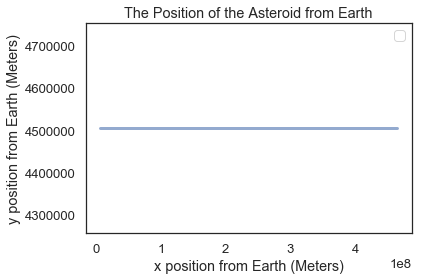

In [16]:
x = results.x
y = results.y
vx = results.v_x

# used to check the trajectory of the asteroid
plot(x,y)

decorate(title="The Position of the Asteroid from Earth",
         xlabel='x position from Earth (Meters)',
         ylabel='y position from Earth (Meters)')


The figure above shows the position of the asteroid as it travels over time. The final position on the graph is the distance traveled when it makes impact with the Earth. There is no change in y as in this section of the model we are calculating direct impact, and later on it will be changed based on the angle of impact. This result is more of raw data, as it will later be adjusted based on angles.

### Results 2: The Change in Velocity over Time as the Asteroid Approaches

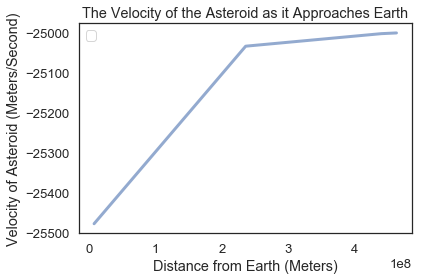

In [17]:
plot(x, vx)
decorate(title="The Velocity of the Asteroid as it Approaches Earth",
         xlabel='Distance from Earth (Meters)',
         ylabel='Velocity of Asteroid (Meters/Second)')

The figure above shows the change in the velocity of the asteroid as it approaches the Earth. as the distance between Earth and the asteroid gets closer, the change in velocity becomes much steeper as the force of Earth's gravity becomes stronger. Based on this model, it seems that around if the Earth is 2.5e8 meters away from Earth, it will begin to accelerate faster towards Earth making it much more difficult to take preventative measures.

### Model 2: Changing the Angle of Approach
The second model implements a change in the angle of approach. The change in angle will affect the amount of energy that will transfer from the asteroid to affect the Earth's rotation. To see the the change in time it takes Earth to complete one rotation depending on the different angle the asteroid strikes, the angle was swept through using a SweepSeries.

Because the initial y position of the asteroid depended on the angle that it would strike Earth, we created a function that would create a new system with different striking angles and initial y positions. Each time we would find the time it takes for one revolution, we used a system with corresponding values depending on the angle that the asteroid strikes. 

In [18]:
def make_system(ang_asteroid, y):
    
    x0 = 4.64e8
    y0 = y # is used to vary y position of the asteroid

    init = State(x = x0 * m, 
                 y = y0 * m, 
                 v_x = -25000 * m/s, 
                 v_y = 0 * m/s, 
                 )
    
    return System(init=init,
                  m_earth = 5.972e24 * kg,
                  c_earth = 40.075e6 * m,
                  Vol_earth = 1.08320692e21 * m**3,
                  init_w_earth = 7.2921159e-5 * rad/s ,
                  density_asteroid = 3200 * kg / m**3,
                  m_asteroid = 2.67e20 * kg,
            
                  G=6.674e-11 * m**3 * kg **-1 * s **-2, 
                  striking_angle = ang_asteroid, # is used to vary the angle of the asteroid
               
                  r_final=r_asteroid + r_earth,
                  t_0=0,
                  t_end=1e10
                 )

## The Math Behind the Model

We implemented the law of conservation of energy in this problem, and modified it as a collision problem as the asteroid will colide into earth. The asteroid is going to stick to earth, making it an inelastic collision. The Equation below is the initial formula that was set up:

$$  t = \frac{1}{2} m_a v_a1^2 + \frac{1}{2}I_Ew_E^2 = \frac{1}{2}(I_a+I_E)w^2$$

It was then rearranged in order to solve for the final angular velocity of the earth.
An assumption that was made was excluding loss of mass of the asteroid that is burned as it enters the earth's atmosphere, and loss of mass as the asteroid and earth make impact as it is possible particles fly around.

In [19]:
def energy_to_velocity(system, v_at_collision):
    """
    Function that converts:
    energy from the asteroid -> angular velocity of the earth
    """
    
    unpack(system)
    
    inertia_earth = (2/5 * m_earth * (r_earth**2))
    inertia_asteroid = (2/5 * m_asteroid * (r_asteroid**2))
    inertia_both = inertia_earth + inertia_asteroid
    
    final_w_earth = sqrt(((m_asteroid * (v_at_collision**2)) + (inertia_earth * (init_w_earth**2))) / inertia_both) 

    return final_w_earth #rad/sec

In [20]:
w = energy_to_velocity(system, v_at_collision)

<Quantity(8.429087092295098e-05, '1 / second')>

The function below calculates the time it takes Earth to complete one revolution depending on its angular velocity that was changed due to the asteroid impact.

The two equations below were used to calculate the time:
$$ t = \frac{\theta}{\omega} $$

$$ \theta = \frac{S}{r}$$

The calculation for deriving t is explained below:
$$ t = \frac{\frac{S}{r}}{\omega} $$

$$ t = \frac{S}{\omega * r} $$

In [21]:
def time_for_revolution(w_earth, system):
    """
    Function that calculates the time it takes for earth 
    to spin depending on the changed angular velocity
    """
    
    unpack(system)
    
    time = c_earth / (r_earth * w_earth) 
    
    return time

In [22]:
output = time_for_revolution(w, system)

<Quantity(74625.17881782132, 'second')>

In [23]:
output.to(UNITS.hours)

<Quantity(20.7292163382837, 'hour')>

# Sweeping Through  Different Angles
Now that we know that the code is working, we will use a SweepSeries to see the time it takes Earth to complete one revolution depending on the different angle the asteroid strikes Earth at the moment of collision.

For this, the asteroid Ceres was selected due to its massive size so that we would be able to see a clear difference.

In [24]:
# making an array of different angles
dA = math.pi / 12 # rad
ang_asteroid = linrange(-math.pi / 2, math.pi / 2, dA, endpoint = True) # rad

# making a SweepSeries
sweep_angle = SweepSeries()


for i in range(len(ang_asteroid)):
    # finds the initial y position that the asteroid has to be at to strike at the desired angle
    y = y_dependingOn_angle(ang_asteroid[i])
    # makes a new system with different angles and y position
    system = make_system(ang_asteroid[i], y)
    
    results, details = run_ode_solver(system, slope_func, events=event_func)
    
    # finds the velocity of the asteroid at the moment of collision
    v_at_collision = get_last_value(results.v_x) * m/s
    
    w = energy_to_velocity(system, v_at_collision)
    output = time_for_revolution(w, system)
    hrs = output.to(UNITS.hours)
    
    # stores the time for one revolution per angle in a SweepSeries
    sweep_angle[ang_asteroid[i]] = hrs
    
    
print(sweep_angle)

-1.570796e+00    20.713491516148316 hour
-1.308997e+00     20.71567607864414 hour
-1.047198e+00     20.72151332404663 hour
-7.853982e-01      20.7292163382837 hour
-5.235988e-01     20.73667916338952 hour
-2.617994e-01    20.742049097705966 hour
-3.330669e-16    20.744007034115466 hour
 2.617994e-01    20.742049097705966 hour
 5.235988e-01     20.73667916338952 hour
 7.853982e-01      20.7292163382837 hour
 1.047198e+00     20.72151332404663 hour
 1.308997e+00     20.71567607864414 hour
 1.570796e+00    20.713491516148316 hour
dtype: object


### Results 1: The Impact of Ceres

Below includes 3 plots, that all compile into 1 result, which is the change in earth's rotation--converted to how long a day will be--after the impact of Ceres.

#### Graph 1

The figure below shows the plotting of the change in days as a form of a complete slope. Based on this model, predictions can be made on theh day length based on the angle of impact.

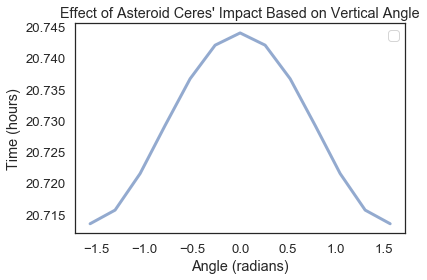

In [25]:
plot(sweep_angle)
decorate(title="Effect of Asteroid Ceres' Impact Based on Vertical Angle",
xlabel='Angle (radians)',
ylabel='Time (hours)')

#### Graph 2

The figure below shows the individual plotting of the calulated day lengths based on individual angles in radians.

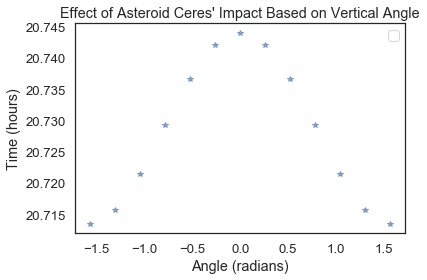

In [26]:
plot(sweep_angle, "*")
decorate(title="Effect of Asteroid Ceres' Impact Based on Vertical Angle",
xlabel='Angle (radians)',
ylabel='Time (hours)')

#### Graph 3

The graph below compiles both of the previous graphs to show the line fit.

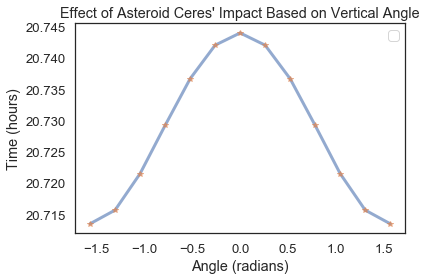

In [27]:
plot(sweep_angle)
plot(sweep_angle, "*")
decorate(title="Effect of Asteroid Ceres' Impact Based on Vertical Angle",
xlabel='Angle (radians)',
ylabel='Time (hours)')

## Interpretation
The graph looks symmetrical as the way this model works, we are sweeping though angles of approach on a vertical axis. Based on the model we can infer that if the asteroid hits below or above the center point of earth, they will produce the same length of the days. However, the graph should exhibit a parabola or a curve of some sort that increases along with the increasing angle, because for negative angles (when the asteroid strikes below 0 radians) the asteroid should slow Earth down in reality. This symmetrical behavior can be explained from the usage of the conservation of energy to calculate the altered angular velocity of the Earth. By using the conservation of energy, the equation disregards whether the asteroid's velocity is going against Earth's angular velocity or whether the asteroid's velocity is going along with Earth's angular velocity. The equation only considers the energy stored in the asteroid's final velocity at the moment of collision.

Another failing in the model is it only takes a change in the horizontal angle impact. We iterated our model multiple times, initially focusing on the change in mass of the asteroid. The failing with that approach however it is very limited and focused on if an asteroid approaches head on in on the y axis of the Earth. It gives a general change in the Earth's rotation, but does not analyze as much possibilies of impact as there actually are.

Apart from the failures, our model accurately proves that the rotation time will be severely effected as the angle nears 90 degrees. When the asteroid strikes at an angle of 0 radians, the rotation time is the longest whereas the 

Iteration was very important in our model because it allowed us to come up with better solution to approaching our answer to the question that we proposed. We started with a basic question of how Earth's mass will affect rotation. We then realized it was too exact of a question as we would have to choose a efficient impact point that would allow the energy transfer to be more effective, limiting impact to one form of approach and one point of impact. We then evolved the question to how angle of approach affects the asteroid's cause of change in rotation.

## Testing the model on 99942 Aphopis

In [28]:
r_asteroid2 = 185 * m
r_earth = 6.371e6 * m;

In [29]:
def make_system2(ang_asteroid, y):
    
    x0 = 4.64e8
    y0 = y

    init = State(x = x0 * m, 
                 y = y0 * m, 
                 v_x = -25000 * m/s, # m/s - X Velocity of Asteroid
                 v_y = 0 * m/s, # m/s - Y Velocity of Asteroid
                 )
    
    return System(init=init,
                  m_earth = 5.972e24 * kg,
                  c_earth = 40.075e6 * m,
                  Vol_earth = 1.08320692e21 * m**3,
                  init_w_earth = 7.2921159e-5 * rad/s,
                  
                  density_asteroid = 3200 * kg / m**3,
                  m_asteroid = 2.699e10 * kg,
            
                  G=6.674e-11 * m**3 * kg **-1 * s **-2, 
                  striking_angle = ang_asteroid,
               
                  r_final=r_asteroid + r_earth,
                  t_0=0,
                  t_end=1e10
                 )

In [30]:
dA = math.pi / 12 # deg
ang_asteroid = linrange(- math.pi / 2, math.pi / 2, dA, endpoint = True) # degrees


aphophis = SweepSeries()


for i in range(len(ang_asteroid)):
    y = y_dependingOn_angle(ang_asteroid[i])
    system = make_system2(ang_asteroid[i], y)
    
    results, details = run_ode_solver(system, slope_func, events=event_func)
    
    v_at_collision = get_last_value(results.v_x) * m/s
    
    w = energy_to_velocity(system, v_at_collision)
    output = time_for_revolution(w, system)
    hrs = output.to(UNITS.hours)
    
    
    aphophis[ang_asteroid[i]] = hrs
    
    
print(aphophis)

-1.570796e+00     23.96127163412655 hour
-1.308997e+00     23.96127163412689 hour
-1.047198e+00     23.96127163412781 hour
-7.853982e-01    23.961271634129016 hour
-5.235988e-01    23.961271634130178 hour
-2.617994e-01    23.961271634131013 hour
-3.330669e-16    23.961271634131318 hour
 2.617994e-01    23.961271634131013 hour
 5.235988e-01    23.961271634130178 hour
 7.853982e-01    23.961271634129016 hour
 1.047198e+00     23.96127163412781 hour
 1.308997e+00     23.96127163412689 hour
 1.570796e+00     23.96127163412655 hour
dtype: object


We have tested our code with another asteroid, 99942 Aphophis. The results of the SweepSeries output an expected behavior, that the time changes by 1e-10. This difference in the time of one revolution between 99942 Aphophis and Ceres is reasonable, as Ceres has a ginormous size and mass compared to 99942 Aphophis. Unfortunately, we were unable to generate an accurate plot for 99942 Aphophis.

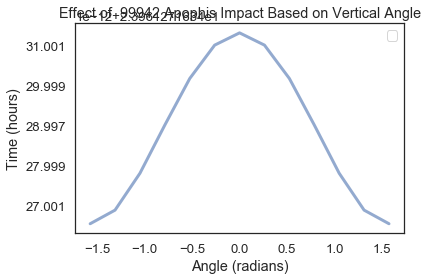

In [31]:
plot(aphophis)
decorate(title="Effect of  99942 Apophis Impact Based on Vertical Angle",
xlabel='Angle (radians)',
ylabel='Time (hours)')